In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install wfdb
!pip install neurokit2
!pip install nolds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 8.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 5.3 MB/s eta 0:00:0000:01


In [4]:
# Part 1/4
# apnea_single_split_eval_highacc_with_features.py
# Pipeline: sequence + tabular features, ensemble feature selection
# Labeling: MIDPOINT rule over WIN_MIN minutes (midpoint -> label)

import os
import wfdb
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from scipy.signal import butter, filtfilt, find_peaks, welch
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis, entropy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Optional libs
try:
    import librosa
    _HAS_LIBROSA = True
except Exception:
    _HAS_LIBROSA = False
try:
    import pywt
    _HAS_PYWT = True
except Exception:
    _HAS_PYWT = False

# ---------------------------
# Config
# ---------------------------
DATASET_PATH = "/kaggle/input/apnea-new-dataset/apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0"
ORIG_FS = 100
WIN_MIN = 7
STRIDE_MIN = 1
WIN_SIZE = ORIG_FS * 60 * WIN_MIN
STEP = ORIG_FS * 60 * STRIDE_MIN
SEQ_LEN = 300
BATCH_SIZE = 64
EPOCHS = 50
LR = 2e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

TARGET_PER_CLASS = 7071
TEST_SIZE = 0.2
TOP_K_FEATURES = 40  # selected via ensemble method

# ---------------------------
# Preprocessing helpers
# ---------------------------
def bandpass(sig, fs=ORIG_FS, low=0.5, high=45.0, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, sig)

def detect_rpeaks(sig, fs=ORIG_FS):
    sig = sig - np.median(sig)
    th = np.median(np.abs(sig)) + 0.5 * np.std(sig)
    min_dist = int(0.35 * fs)
    peaks, _ = find_peaks(np.abs(sig), height=th, distance=min_dist)
    return peaks

def build_rri_ra(segment, fs=ORIG_FS):
    peaks = detect_rpeaks(segment, fs)
    if len(peaks) < 2:
        return None
    rri = np.diff(peaks) * 1000 / fs
    ra = segment[peaks[:-1]]
    return rri.astype(np.float32), ra.astype(np.float32)

def resample_seq(seq, target_len=SEQ_LEN):
    if len(seq) < 2:
        return np.zeros(target_len, dtype=np.float32)
    x_old = np.linspace(0, 1, len(seq))
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, seq, kind="linear", fill_value="extrapolate")
    return f(x_new).astype(np.float32)

def augment_signal(sig):
    sig = sig + np.random.normal(0, 0.01 * np.std(sig), sig.shape)
    if random.random() < 0.5:
        sig = sig * (0.9 + 0.2 * np.random.rand())
    return sig

# ---------------------------
# Feature extraction
# ---------------------------
def time_domain_features(x):
    feats = []
    if len(x) == 0:
        return [0.0]*10
    feats.append(np.mean(x))
    feats.append(np.std(x))
    feats.append(np.median(x))
    feats.append(np.min(x))
    feats.append(np.max(x))
    feats.append(np.ptp(x))
    feats.append(np.sqrt(np.mean(x**2)))
    feats.append(skew(x) if len(x) > 2 else 0.0)
    feats.append(kurtosis(x) if len(x) > 2 else 0.0)
    p, _ = np.histogram(x, bins=10, density=True)
    p = p[p > 0]
    feats.append(entropy(p) if p.size > 0 else 0.0)
    return feats

def frequency_domain_features(x, fs=ORIG_FS):
    if len(x) < 2:
        return [0.0]*8
    f, Pxx = welch(x, fs=fs, nperseg=min(len(x), 256))
    Psum = np.sum(Pxx) + 1e-12
    centroid = np.sum(f * Pxx) / Psum
    bw = np.sqrt(np.sum(((f - centroid)**2) * Pxx) / Psum)
    dom = f[np.argmax(Pxx)]
    p = Pxx / Psum
    spec_ent = entropy(p + 1e-12)
    low_band = np.sum(Pxx[(f >= 0.5) & (f < 4)])
    mid_band = np.sum(Pxx[(f >= 4) & (f < 15)])
    high_band = np.sum(Pxx[(f >= 15) & (f <= fs/2)])
    total = low_band + mid_band + high_band + 1e-12
    return [centroid, bw, dom, spec_ent, low_band/total, mid_band/total, high_band/total, np.log(total+1e-12)]

def cepstral_features(x, fs=ORIG_FS, n_mfcc=13):
    if len(x) < 2:
        return [0.0]*n_mfcc
    if _HAS_LIBROSA:
        try:
            mfccs = librosa.feature.mfcc(y=x.astype(float), sr=fs, n_mfcc=n_mfcc)
            mfcc_mean = np.mean(mfccs, axis=1)
            return mfcc_mean.tolist()
        except Exception:
            pass
    X = np.fft.rfft(x * np.hanning(len(x)))
    log_spec = np.log(np.abs(X) + 1e-12)
    cep = np.real(np.fft.ifft(np.concatenate([log_spec, log_spec[::-1]])))[:n_mfcc]
    cep = np.pad(cep, (0, max(0, n_mfcc - len(cep))), 'constant')[:n_mfcc]
    return cep.tolist()

def dwt_features(x, wavelet='db4', level=3):
    if len(x) < 2:
        return [0.0]*(level+1)
    if _HAS_PYWT:
        try:
            coeffs = pywt.wavedec(x, wavelet, level=level)
            energies = [np.log(np.sum(c**2) + 1e-12) for c in coeffs]
            if len(energies) < (level+1):
                energies += [0.0] * ((level+1) - len(energies))
            return energies[:(level+1)]
        except Exception:
            pass
    f, Pxx = welch(x, fs=ORIG_FS, nperseg=min(len(x), 256))
    bands = np.array_split(Pxx, level+1)
    energies = [np.log(np.sum(b)+1e-12) for b in bands]
    return energies

def extract_tabular_features(window, fs=ORIG_FS):
    feats = []
    feats += time_domain_features(window)
    feats += frequency_domain_features(window, fs)
    feats += cepstral_features(window, fs, n_mfcc=8)
    feats += dwt_features(window, level=3)
    rri_ra = build_rri_ra(window, fs)
    if rri_ra is None:
        feats += [0.0]*10
    else:
        rri, ra = rri_ra
        feats += time_domain_features(rri)
        feats += time_domain_features(ra)
    return np.array(feats, dtype=np.float32)


In [5]:
# Part 2/4
# ---------------------------
# Index Builder (Midpoint Rule)
# ---------------------------
def build_index(records, win_min=WIN_MIN):
    idx = []
    for rec in records:
        try:
            ann = wfdb.rdann(os.path.join(DATASET_PATH, rec), "apn")
            labels = ann.symbol
            total_len = wfdb.rdrecord(os.path.join(DATASET_PATH, rec)).p_signal.shape[0]
        except Exception:
            continue

        starts = range(0, total_len - WIN_SIZE + 1, STEP)
        for s in starts:
            start_min = s // (ORIG_FS * 60)
            end_min = start_min + win_min

            window_labels = labels[start_min:end_min]
            if len(window_labels) < win_min:
                continue

            # --------- MIDPOINT RULE ----------
            mid_idx = win_min // 2
            mid_label = window_labels[mid_idx]
            lab = 1 if mid_label == "A" else 0

            idx.append((rec, s, lab))
    return idx

# ---------------------------
# Dataset (returns seq + tabular features)
# ---------------------------
class ApneaDatasetWithFeatures(Dataset):
    def __init__(self, index, feats_list, seq_len=SEQ_LEN, augment=False):
        self.index = index
        self.feats_list = feats_list  # precomputed aligned tabular features (same order as 'index')
        self.seq_len = seq_len
        self.augment = augment

    def __len__(self): return len(self.index)

    def __getitem__(self, idx):
        rec, s, label = self.index[idx]
        sig = wfdb.rdrecord(os.path.join(DATASET_PATH, rec)).p_signal[:, 0].astype(np.float32)
        window = sig[s:s + WIN_SIZE]
        if self.augment:
            window = augment_signal(window)
        window = bandpass(window)
        result = build_rri_ra(window)
        if result is None:
            feat_seq = np.zeros((self.seq_len, 2), dtype=np.float32)
        else:
            rri, ra = result
            if np.std(rri) > 0:
                rri = (rri - np.mean(rri)) / (np.std(rri) + 1e-6)
            else:
                rri = rri - np.mean(rri)
            if np.std(ra) > 0:
                ra = (ra - np.mean(ra)) / (np.std(ra) + 1e-6)
            else:
                ra = ra - np.mean(ra)
            feat_seq = np.stack([resample_seq(rri, self.seq_len),
                                 resample_seq(ra, self.seq_len)], axis=1)
        tab_feat = self.feats_list[idx]  # already aligned numeric vector
        return torch.from_numpy(feat_seq), torch.from_numpy(tab_feat), torch.tensor(label, dtype=torch.long)


In [6]:
# Part 3/4
# ---------------------------
# Model (concat sequence features + tabular features)
# ---------------------------
class EnhancedCNNBiLSTMTransformerWithTabs(nn.Module):
    def __init__(self, in_ch=2, hidden=128, extra_feat_dim=0):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_ch, 128, 7, padding=3), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 256, 5, padding=2), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Conv1d(256, 256, 3, padding=1), nn.BatchNorm1d(256), nn.ReLU(),
            nn.AdaptiveAvgPool1d(100)
        )
        self.lstm = nn.LSTM(256, hidden, batch_first=True, bidirectional=True, dropout=0.3)
        proj_dim = 256
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=proj_dim, nhead=8, dim_feedforward=512,
            dropout=0.3, batch_first=True, norm_first=True
        )
        self.trans = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.extra_feat_dim = extra_feat_dim
        if extra_feat_dim > 0:
            self.tab_proj = nn.Sequential(
                nn.Linear(extra_feat_dim, 128), nn.LayerNorm(128), nn.ReLU(), nn.Dropout(0.2)
            )
            fc_input_dim = proj_dim + 128
        else:
            self.tab_proj = None
            fc_input_dim = proj_dim

        self.fc = nn.Sequential(
            nn.Linear(fc_input_dim, 128), nn.LayerNorm(128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x, tab=None):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        _, (h, _) = self.lstm(x)
        feat = torch.cat([h[-2], h[-1]], dim=1).unsqueeze(1)
        feat = self.trans(feat).mean(dim=1)
        if self.extra_feat_dim > 0 and tab is not None:
            t = self.tab_proj(tab)
            combined = torch.cat([feat, t], dim=1)
        else:
            combined = feat
        return self.fc(combined)

# ---------------------------
# Ensemble feature selection
# ---------------------------
def ensemble_feature_selection(X_train, y_train, K=TOP_K_FEATURES, random_state=SEED):
    f_vals, _ = f_classif(X_train, y_train)
    mi_vals = mutual_info_classif(X_train, y_train, random_state=random_state)
    rf = RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_imp = rf.feature_importances_
    def norm(x): return (x - np.min(x)) / (np.ptp(x) + 1e-12)
    s_f = norm(f_vals)
    s_mi = norm(mi_vals)
    s_rf = norm(rf_imp)
    agg = (s_f + s_mi + s_rf) / 3.0
    top_idx = np.argsort(agg)[::-1][:K]
    scores = agg[top_idx]
    return top_idx, scores

# ---------------------------
# Training utilities (adapted to dataset with tabular features)
# ---------------------------
def train_epoch_with_tabs(model, loader, opt, crit):
    model.train()
    total = 0
    for X, tab, y in tqdm(loader, desc="Train"):
        X, tab, y = X.to(DEVICE), tab.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        out = model(X, tab)
        loss = crit(out, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()
        total += loss.item()
    return total / max(1, len(loader))

def evaluate_with_tabs(model, loader):
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for X, tab, y in loader:
            X = X.to(DEVICE)
            tab = tab.to(DEVICE)
            out = model(X, tab)
            pred = out.argmax(1).cpu().tolist()
            preds += pred
            gts += y.tolist()
    return np.array(gts), np.array(preds)


Building index using midpoint labeling...
Precomputing tabular features for all windows... (this may take a while)


100%|██████████| 14142/14142 [09:23<00:00, 25.12it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Selected top-40 feature indices (ensemble): [39 31  3 25 26 24  4 44 13  5 43  1 32 27  6 17 33 16 45 22 38 28 48  2
  8 11 10 23 46  7 29 19 42 15 18 30 20 49 40 36]


Train: 100%|██████████| 177/177 [02:30<00:00,  1.18it/s]


Epoch 1: Loss=0.5461, Acc=0.8590, F1=0.8612


Train: 100%|██████████| 177/177 [02:29<00:00,  1.18it/s]


Epoch 2: Loss=0.3653, Acc=0.8830, F1=0.8810


Train: 100%|██████████| 177/177 [02:31<00:00,  1.17it/s]


Epoch 3: Loss=0.3204, Acc=0.8841, F1=0.8759


Train: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]


Epoch 4: Loss=0.2982, Acc=0.8763, F1=0.8794


Train: 100%|██████████| 177/177 [02:30<00:00,  1.17it/s]


Epoch 5: Loss=0.2682, Acc=0.9031, F1=0.8991


Train: 100%|██████████| 177/177 [02:29<00:00,  1.18it/s]


Epoch 6: Loss=0.2605, Acc=0.9127, F1=0.9112


Train: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]


Epoch 7: Loss=0.2383, Acc=0.8904, F1=0.8858


Train: 100%|██████████| 177/177 [02:32<00:00,  1.16it/s]


Epoch 8: Loss=0.2298, Acc=0.8950, F1=0.8858


Train: 100%|██████████| 177/177 [02:30<00:00,  1.18it/s]


Epoch 9: Loss=0.2106, Acc=0.8607, F1=0.8748


Train: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]


Epoch 10: Loss=0.1959, Acc=0.8918, F1=0.8837


Train: 100%|██████████| 177/177 [02:30<00:00,  1.17it/s]


Epoch 11: Loss=0.1973, Acc=0.9219, F1=0.9203


Train: 100%|██████████| 177/177 [02:30<00:00,  1.18it/s]


Epoch 12: Loss=0.1683, Acc=0.9275, F1=0.9277


Train: 100%|██████████| 177/177 [02:28<00:00,  1.19it/s]


Epoch 13: Loss=0.1542, Acc=0.9162, F1=0.9146


Train: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]


Epoch 14: Loss=0.1523, Acc=0.9364, F1=0.9372


Train: 100%|██████████| 177/177 [02:32<00:00,  1.16it/s]


Epoch 15: Loss=0.1352, Acc=0.9325, F1=0.9329


Train: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]


Epoch 16: Loss=0.1263, Acc=0.9463, F1=0.9454


Train: 100%|██████████| 177/177 [02:28<00:00,  1.20it/s]


Epoch 17: Loss=0.1154, Acc=0.9328, F1=0.9323


Train: 100%|██████████| 177/177 [02:32<00:00,  1.16it/s]


Epoch 18: Loss=0.1038, Acc=0.9424, F1=0.9431


Train: 100%|██████████| 177/177 [02:31<00:00,  1.17it/s]


Epoch 19: Loss=0.0953, Acc=0.9385, F1=0.9363


Train: 100%|██████████| 177/177 [02:34<00:00,  1.14it/s]


Epoch 20: Loss=0.0874, Acc=0.9505, F1=0.9495


Train: 100%|██████████| 177/177 [02:33<00:00,  1.15it/s]


Epoch 21: Loss=0.0722, Acc=0.9452, F1=0.9429


Train: 100%|██████████| 177/177 [02:31<00:00,  1.17it/s]


Epoch 22: Loss=0.0670, Acc=0.9463, F1=0.9469


Train: 100%|██████████| 177/177 [02:31<00:00,  1.16it/s]


Epoch 23: Loss=0.0559, Acc=0.9544, F1=0.9535


Train: 100%|██████████| 177/177 [02:30<00:00,  1.17it/s]


Epoch 24: Loss=0.0502, Acc=0.9540, F1=0.9537


Train: 100%|██████████| 177/177 [02:29<00:00,  1.18it/s]


Epoch 25: Loss=0.0471, Acc=0.9495, F1=0.9487


Train: 100%|██████████| 177/177 [02:30<00:00,  1.18it/s]


Epoch 26: Loss=0.0428, Acc=0.9551, F1=0.9542


Train: 100%|██████████| 177/177 [02:31<00:00,  1.17it/s]


Epoch 27: Loss=0.0333, Acc=0.9604, F1=0.9604


Train: 100%|██████████| 177/177 [02:30<00:00,  1.17it/s]


Epoch 28: Loss=0.0266, Acc=0.9544, F1=0.9541


Train: 100%|██████████| 177/177 [02:29<00:00,  1.19it/s]


Epoch 29: Loss=0.0288, Acc=0.9572, F1=0.9575


Train: 100%|██████████| 177/177 [02:31<00:00,  1.17it/s]


Epoch 30: Loss=0.0253, Acc=0.9601, F1=0.9597


Train: 100%|██████████| 177/177 [02:35<00:00,  1.14it/s]


Epoch 31: Loss=0.0196, Acc=0.9597, F1=0.9588


Train: 100%|██████████| 177/177 [02:33<00:00,  1.15it/s]


Epoch 32: Loss=0.0217, Acc=0.9622, F1=0.9617


Train: 100%|██████████| 177/177 [02:32<00:00,  1.16it/s]


Epoch 33: Loss=0.0172, Acc=0.9601, F1=0.9596


Train: 100%|██████████| 177/177 [02:33<00:00,  1.15it/s]


Epoch 34: Loss=0.0150, Acc=0.9586, F1=0.9582


Train: 100%|██████████| 177/177 [02:31<00:00,  1.17it/s]


Epoch 35: Loss=0.0136, Acc=0.9597, F1=0.9590


Train: 100%|██████████| 177/177 [02:32<00:00,  1.16it/s]


Epoch 36: Loss=0.0102, Acc=0.9611, F1=0.9606


Train: 100%|██████████| 177/177 [02:35<00:00,  1.14it/s]


Epoch 37: Loss=0.0094, Acc=0.9622, F1=0.9619


Train: 100%|██████████| 177/177 [02:32<00:00,  1.16it/s]


Epoch 38: Loss=0.0091, Acc=0.9611, F1=0.9607


Train: 100%|██████████| 177/177 [02:33<00:00,  1.15it/s]


Epoch 39: Loss=0.0058, Acc=0.9654, F1=0.9651


Train: 100%|██████████| 177/177 [02:33<00:00,  1.15it/s]


Epoch 40: Loss=0.0080, Acc=0.9622, F1=0.9619


Train: 100%|██████████| 177/177 [02:33<00:00,  1.15it/s]


Epoch 41: Loss=0.0065, Acc=0.9639, F1=0.9637


Train: 100%|██████████| 177/177 [02:34<00:00,  1.15it/s]


Epoch 42: Loss=0.0057, Acc=0.9601, F1=0.9596


Train: 100%|██████████| 177/177 [02:34<00:00,  1.15it/s]


Epoch 43: Loss=0.0078, Acc=0.9625, F1=0.9623


Train: 100%|██████████| 177/177 [02:34<00:00,  1.15it/s]


Epoch 44: Loss=0.0047, Acc=0.9590, F1=0.9584


Train: 100%|██████████| 177/177 [02:35<00:00,  1.14it/s]


Epoch 45: Loss=0.0041, Acc=0.9611, F1=0.9607
Early stopping triggered.
Evaluating best model...
Accuracy=0.9654, F1=0.9651, Kappa=0.9307
              precision    recall  f1-score   support

   Non-Apnea       0.96      0.97      0.97      1415
       Apnea       0.97      0.96      0.97      1414

    accuracy                           0.97      2829
   macro avg       0.97      0.97      0.97      2829
weighted avg       0.97      0.97      0.97      2829



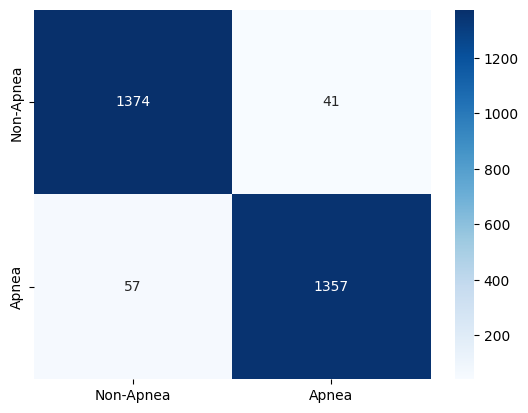

In [7]:
# Part 4/4
# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    # Records naming assumption (change if different)
    records = [f"a{str(i).zfill(2)}" for i in range(1, 21)]

    print("Building index using midpoint labeling...")
    index = build_index(records)
    if len(index) == 0:
        raise RuntimeError("No index entries found. Check DATASET_PATH, WIN_SIZE, STEP or record names.")

    pos = [x for x in index if x[2] == 1]
    neg = [x for x in index if x[2] == 0]

    def sample_fixed(lst, n):
        return random.sample(lst, n) if len(lst) >= n else lst + random.choices(lst, k=n - len(lst))

    pos, neg = sample_fixed(pos, TARGET_PER_CLASS), sample_fixed(neg, TARGET_PER_CLASS)
    balanced = pos + neg
    random.shuffle(balanced)
    labels = np.array([x[2] for x in balanced])

    print("Precomputing tabular features for all windows... (this may take a while)")
    all_feats = []
    for (rec, s, lab) in tqdm(balanced):
        try:
            sig = wfdb.rdrecord(os.path.join(DATASET_PATH, rec)).p_signal[:, 0].astype(np.float32)
            window = sig[s:s + WIN_SIZE]
            window = bandpass(window)
            feat_vec = extract_tabular_features(window, ORIG_FS)
        except Exception:
            feat_vec = np.zeros((10 + 8 + 8 + 4 + 10 + 10), dtype=np.float32)
        all_feats.append(feat_vec)

    # convert to array (pad/truncate to max length)
    max_len = max([f.shape[0] for f in all_feats])
    feat_mat = np.zeros((len(all_feats), max_len), dtype=np.float32)
    for i, f in enumerate(all_feats):
        L = f.shape[0]
        feat_mat[i, :L] = f

    # handle NaN/inf and scale
    imp = SimpleImputer(strategy="median")
    feat_mat = imp.fit_transform(feat_mat)
    scaler = StandardScaler()
    feat_mat = scaler.fit_transform(feat_mat)

    # Train-test split (must align with features)
    indices = np.arange(len(balanced))
    train_idx, test_idx = train_test_split(indices, test_size=TEST_SIZE, stratify=labels, random_state=SEED)
    X_train_feats = feat_mat[train_idx]
    y_train = labels[train_idx]
    X_test_feats = feat_mat[test_idx]
    y_test = labels[test_idx]

    # ensemble feature selection on training set
    top_idx, scores = ensemble_feature_selection(X_train_feats, y_train, K=TOP_K_FEATURES)
    print(f"Selected top-{TOP_K_FEATURES} feature indices (ensemble):", top_idx)
    X_train_sel = X_train_feats[:, top_idx]
    X_test_sel = X_test_feats[:, top_idx]

    # align selected features back to datasets in original balanced order
    selected_feats_ordered = feat_mat[:, top_idx].astype(np.float32)

    # split indices again to build dataset lists
    train_index = [balanced[i] for i in train_idx]
    test_index = [balanced[i] for i in test_idx]
    train_feats_list = [selected_feats_ordered[i] for i in train_idx]
    test_feats_list = [selected_feats_ordered[i] for i in test_idx]

    # DataLoaders (dataset returns seq, tab, label)
    train_ds = ApneaDatasetWithFeatures(train_index, np.array(train_feats_list), augment=True)
    test_ds = ApneaDatasetWithFeatures(test_index, np.array(test_feats_list), augment=False)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

    # Model
    model = EnhancedCNNBiLSTMTransformerWithTabs(extra_feat_dim=TOP_K_FEATURES).to(DEVICE)
    class_counts = np.bincount(labels)
    class_counts = np.where(class_counts == 0, 1, class_counts)
    weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]], dtype=torch.float32).to(DEVICE)
    crit = nn.CrossEntropyLoss(weight=weights)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

    best_f1, patience, wait = 0, 6, 0
    for ep in range(EPOCHS):
        loss = train_epoch_with_tabs(model, train_loader, opt, crit)
        scheduler.step()
        gts, preds = evaluate_with_tabs(model, test_loader)
        f1 = f1_score(gts, preds, zero_division=0)
        acc = accuracy_score(gts, preds) if len(gts) > 0 else 0.0
        print(f"Epoch {ep+1}: Loss={loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1; wait = 0
            torch.save(model.state_dict(), "best_apnea_model_with_feats.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    print("Evaluating best model...")
    model.load_state_dict(torch.load("best_apnea_model_with_feats.pth"))
    gts, preds = evaluate_with_tabs(model, test_loader)
    acc = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds, zero_division=0)
    kappa = cohen_kappa_score(gts, preds)
    print(f"Accuracy={acc:.4f}, F1={f1:.4f}, Kappa={kappa:.4f}")
    print(classification_report(gts, preds, target_names=["Non-Apnea", "Apnea"], zero_division=0))
    cm = confusion_matrix(gts, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Apnea","Apnea"],
                yticklabels=["Non-Apnea","Apnea"])
    plt.show()
